In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import hashlib
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Sample-Superstore.csv", encoding='latin-1')
# # Load the dataset
# file_path = 'Sample - Superstore.csv'  # Replace with your file path
# df = pd.read_csv(file_path, encoding='latin1')

In [3]:
print(df.isna().sum())

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


In [4]:
# Data Cleaning and Preparation
# Make sure to handle mixed date formats correctly
def parse_mixed_date(date_str):
    try:
        return pd.to_datetime(date_str, format='%m/%d/%Y')  # Try MM/DD/YYYY first
    except ValueError:
        try:
            return pd.to_datetime(date_str, format='%d-%m-%Y')  # Try DD-MM-YYYY if MM/DD/YYYY fails
        except ValueError:
            return pd.NaT  # Return Not a Time if both fail

df['Order Date'] = df['Order Date'].apply(parse_mixed_date)
df['Ship Date'] = df['Ship Date'].apply(parse_mixed_date)

In [5]:
# df['Order Date'] = pd.to_datetime(df['Order Date'], format='mixed', dayfirst=True)
# df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='mixed', dayfirst=True)

In [6]:
# Data Cleaning and Preparation
# Assuming your date format is MM/DD/YYYY
# df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
# df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y') #apply also to the ship date.
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df.dropna(subset=['Sales', 'Profit', 'Quantity'], inplace=True)
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Quarter'] = df['Order Date'].dt.quarter
df['Shipping Time'] = (df['Ship Date'] - df['Order Date']).dt.days

# 1. Which product categories generate the most profit?

1. Product Categories Generating Most Profit:
 Category
Technology         145454.9481
Office Supplies    122490.8008
Furniture           18451.2728
Name: Profit, dtype: float64


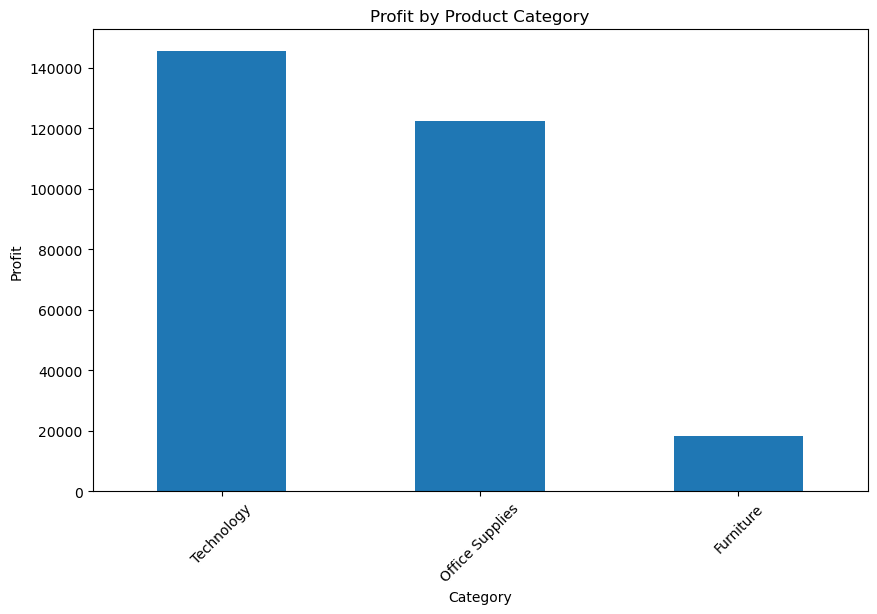

In [7]:
category_profit = df.groupby('Category')['Profit'].sum().sort_values(ascending=False)
print("1. Product Categories Generating Most Profit:\n", category_profit)
plt.figure(figsize=(10, 6))
category_profit.plot(kind='bar')
plt.title('Profit by Product Category')
plt.xlabel('Category')
plt.ylabel('Profit')
plt.xticks(rotation=45)
plt.show()

In [8]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'Order Year',
       'Order Month', 'Order Quarter', 'Shipping Time'],
      dtype='object')

In [9]:
# Recency
max_date = df['Order Date'].max()
rfm_recency = df.groupby('Customer ID')['Order Date'].max().apply(lambda x: (max_date - x).days)

# Frequency
rfm_frequency = df.groupby('Customer ID')['Order ID'].nunique()

# Monetary Value (Sales)
rfm_monetary_sales = df.groupby('Customer ID')['Sales'].sum()

# Monetary Value (Profit)
rfm_monetary_profit = df.groupby('Customer ID')['Profit'].sum()

# Create RFM DataFrame
rfm_df1 = pd.DataFrame({
        'Recency': rfm_recency,
        'Frequency': rfm_frequency,
        'Sales': rfm_monetary_sales,
        'Profit': rfm_monetary_profit
})

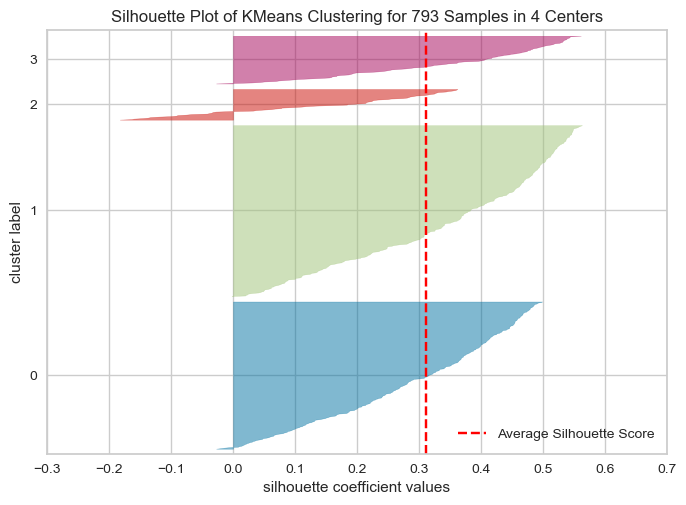

Average silhouette score is : 0.3114757845864133


In [10]:
# Import necessary libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df1)

# K-Means Clustering (Example: 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df1['Cluster'] = kmeans.fit_predict(rfm_scaled)

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(rfm_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figur
# Compute the average silhouette score
silhouette_avg = silhouette_score(rfm_scaled, rfm_df1['Cluster'])
print('Average silhouette score is :' , silhouette_avg)

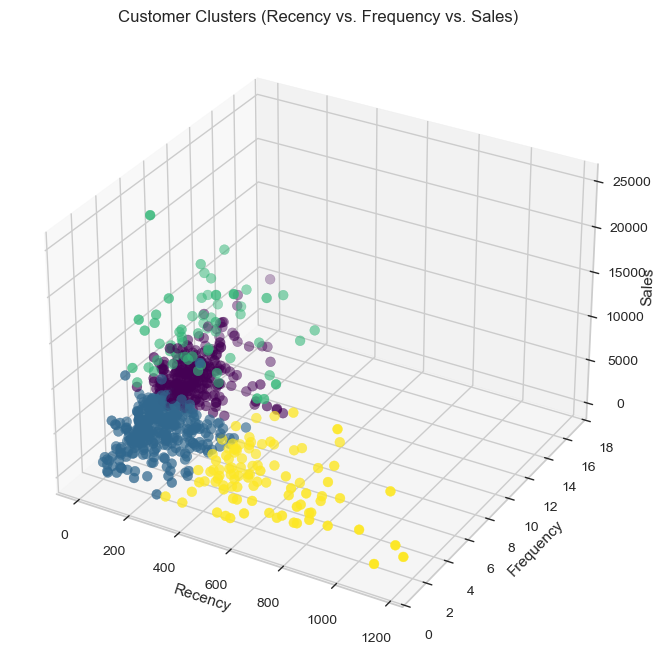

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rfm_df1['Recency'], rfm_df1['Frequency'], rfm_df1['Sales'], c=rfm_df1['Cluster'], cmap='viridis', s=50)  # Use 'c' for color based on Cluster_Id

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Sales')  # Replace 'Frequency' with your third dimension label
ax.set_title('Customer Clusters (Recency vs. Frequency vs. Sales)')  # Update title
plt.show()

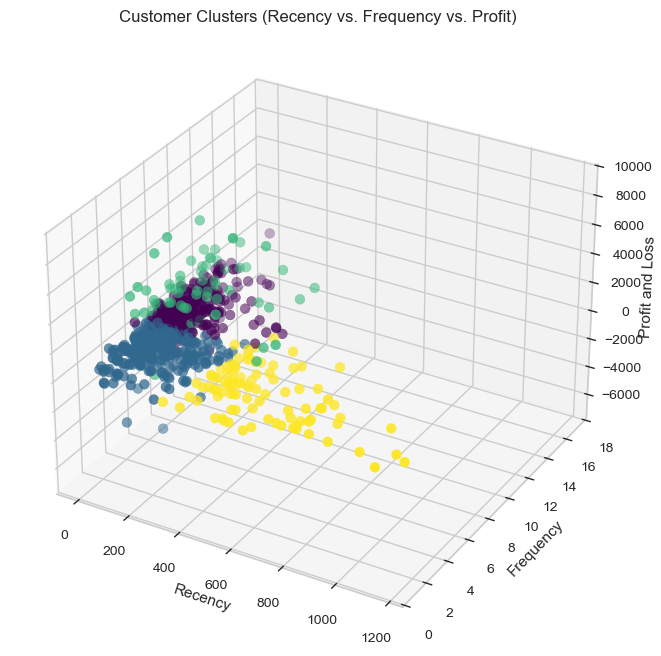

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rfm_df1['Recency'], rfm_df1['Frequency'], rfm_df1['Profit'], c=rfm_df1['Cluster'], cmap='viridis', s=50)  # Use 'c' for color based on Cluster_Id

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Profit and Loss')  # Replace 'Frequency' with your third dimension label
ax.set_title('Customer Clusters (Recency vs. Frequency vs. Profit)')  # Update title
plt.show()

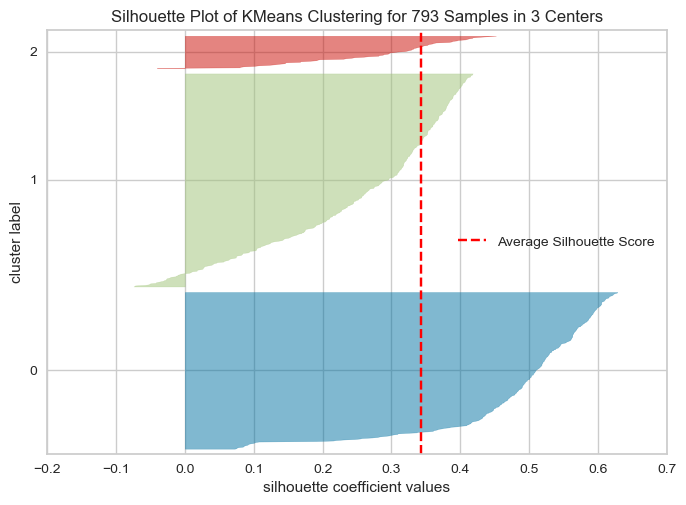

Average silhouette score is : 0.34327314988680796


In [13]:
# Import necessary libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df1)

# K-Means Clustering (Example: 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
rfm_df1['Cluster'] = kmeans.fit_predict(rfm_scaled)

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(rfm_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figur
# Compute the average silhouette score
silhouette_avg = silhouette_score(rfm_scaled, rfm_df1['Cluster'])
print('Average silhouette score is :' , silhouette_avg)

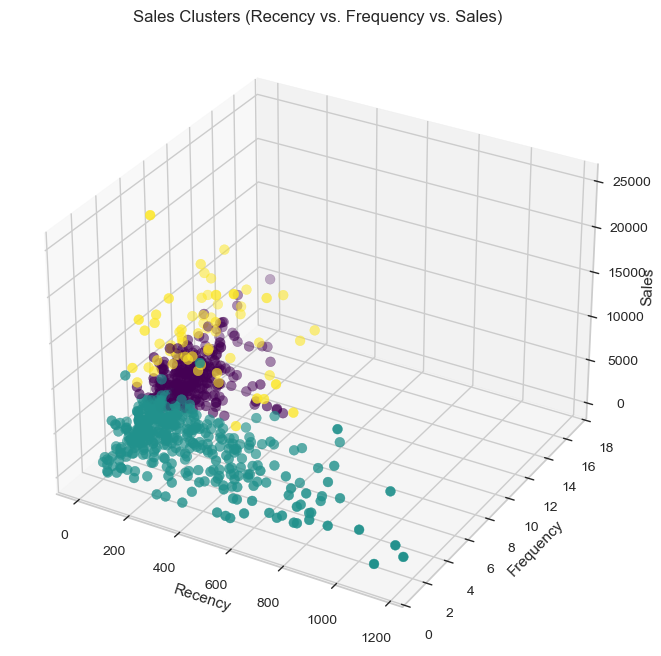

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rfm_df1['Recency'], rfm_df1['Frequency'], rfm_df1['Sales'], c=rfm_df1['Cluster'], cmap='viridis', s=50)  # Use 'c' for color based on Cluster_Id

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Sales')  # Replace 'Frequency' with your third dimension label
ax.set_title('Sales Clusters (Recency vs. Frequency vs. Sales)')  # Update title
plt.show()

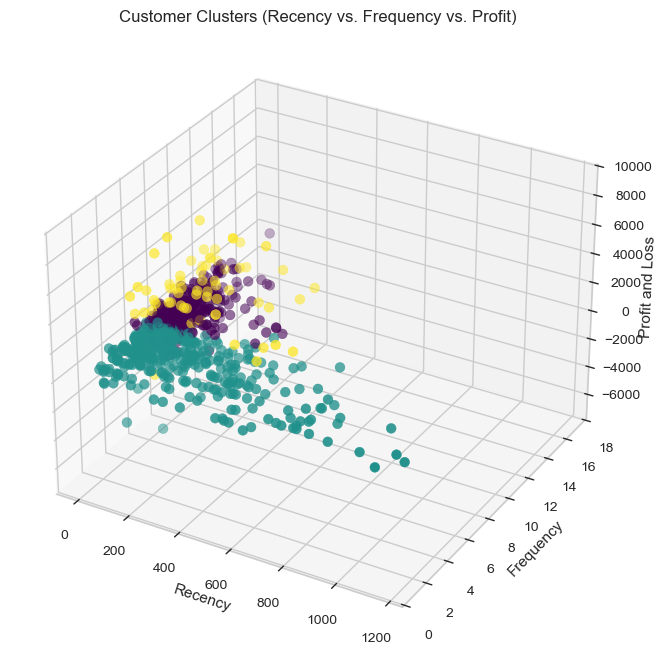

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rfm_df1['Recency'], rfm_df1['Frequency'], rfm_df1['Profit'], c=rfm_df1['Cluster'], cmap='viridis', s=50)  # Use 'c' for color based on Cluster_Id

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Profit and Loss')  # Replace 'Frequency' with your third dimension label
ax.set_title('Customer Clusters (Recency vs. Frequency vs. Profit)')  # Update title
plt.show()

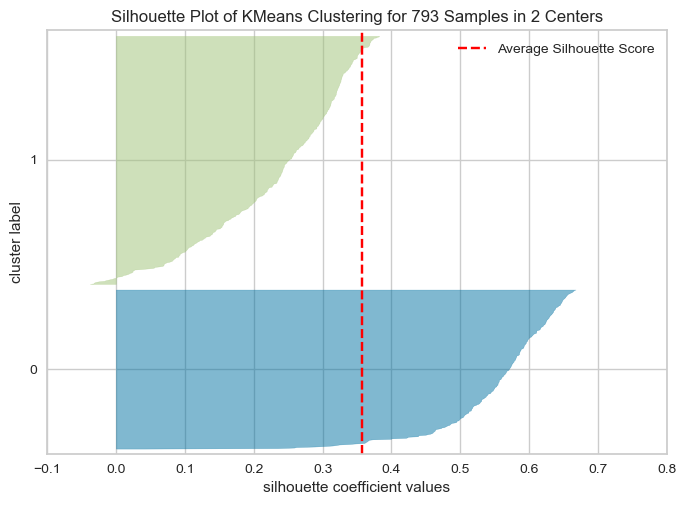

Average silhouette score is : 0.35699391420327614


In [16]:
# Import necessary libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df1)

# K-Means Clustering (Example: 2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42)
rfm_df1['Cluster'] = kmeans.fit_predict(rfm_scaled)

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(rfm_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figur
# Compute the average silhouette score
silhouette_avg = silhouette_score(rfm_scaled, rfm_df1['Cluster'])
print('Average silhouette score is :' , silhouette_avg)

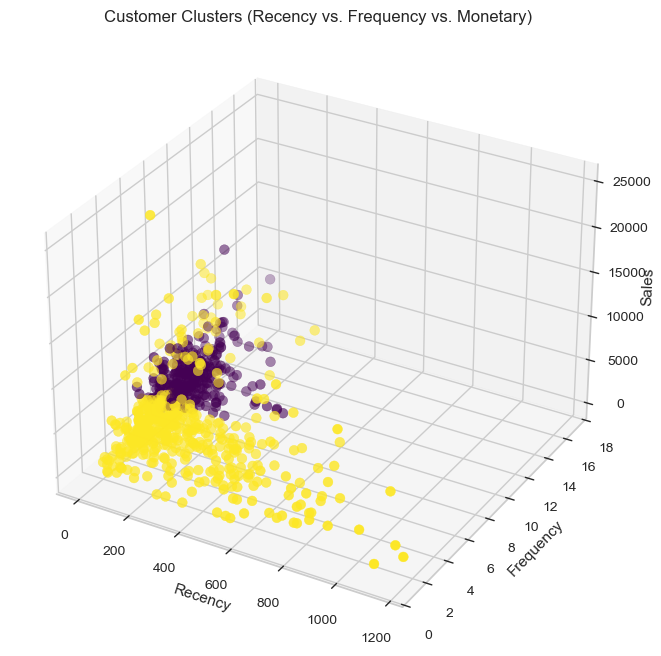

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rfm_df1['Recency'], rfm_df1['Frequency'], rfm_df1['Sales'], c=rfm_df1['Cluster'], cmap='viridis', s=50)  # Use 'c' for color based on Cluster_Id

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Sales')  # Replace 'Frequency' with your third dimension label
ax.set_title('Customer Clusters (Recency vs. Frequency vs. Monetary)')  # Update title
plt.show()

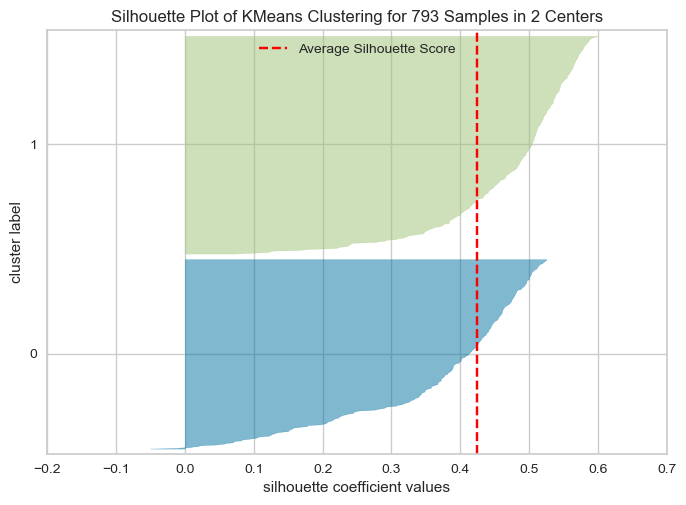

Average silhouette score is : 0.4247823068526066


In [18]:
# Import necessary libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df1)

# K-Means Clustering (Example: 2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42)
rfm_df1['Cluster'] = kmeans.fit_predict(rfm_scaled)

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(rfm_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figur
# Compute the average silhouette score
silhouette_avg = silhouette_score(rfm_scaled, rfm_df1['Cluster'])
print('Average silhouette score is :' , silhouette_avg)

In [19]:
rfm_df1.head()

,Recency,Frequency,Sales,Profit,Cluster
Customer ID,,,,,
AA-10315,184,5,5563.560,-362.8825,1
AA-10375,19,9,1056.390,277.3824,0
AA-10480,259,4,1790.512,435.8274,1
AA-10645,55,6,5086.935,857.8033,0
AB-10015,415,3,886.156,129.3465,1


In [20]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(rfm_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.4247823068526066
For n_clusters=3, the silhouette score is 0.40506408402204497
For n_clusters=4, the silhouette score is 0.4742446599783495
For n_clusters=5, the silhouette score is 0.4082211048887149
For n_clusters=6, the silhouette score is 0.3462179511406698
For n_clusters=7, the silhouette score is 0.4226617818664325
For n_clusters=8, the silhouette score is 0.23877216285674796
